In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../../dataset/df_cleaned_1atc.tsv", sep="\t")
df["drug_era_start_date"] = pd.to_datetime(df["drug_era_start_date"])
df["drug_era_end_date"] = pd.to_datetime(df["drug_era_end_date"])
df_n06a = (
    df[df["atc_level3"] == "N06A"]
    .sort_values(by=["eid", "drug_era_start_date"])
    .reset_index(drop=True)
)
df_n06a.head()

,eid,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration,atc_level3
0,1000014,128849065239,710062,2010-02-15,2010-02-26,2,0,amitriptyline,N06AA09,12,N06A
1,1000014,1245540543307,710062,2010-04-23,2010-04-30,1,0,amitriptyline,N06AA09,8,N06A
2,1000014,670014960364,710062,2010-06-25,2010-07-02,1,0,amitriptyline,N06AA09,8,N06A
3,1000014,1228360666726,710062,2014-03-10,2014-03-17,1,0,amitriptyline,N06AA09,8,N06A
4,1000041,661424994579,797617,2014-02-14,2014-02-27,1,0,citalopram,N06AB04,14,N06A


In [3]:
len(np.unique(df_n06a["eid"]))

69066

In [4]:
# create a mapping for each atc_code to a number
atc_code_to_num = {
    atc_code: i + 1 for i, atc_code in enumerate(df_n06a["atc_code"].unique())
}
df_n06a["atc_code_num"] = df_n06a["atc_code"].map(atc_code_to_num)
df_n06a.head()

,eid,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration,atc_level3,atc_code_num
0,1000014,128849065239,710062,2010-02-15,2010-02-26,2,0,amitriptyline,N06AA09,12,N06A,1
1,1000014,1245540543307,710062,2010-04-23,2010-04-30,1,0,amitriptyline,N06AA09,8,N06A,1
2,1000014,670014960364,710062,2010-06-25,2010-07-02,1,0,amitriptyline,N06AA09,8,N06A,1
3,1000014,1228360666726,710062,2014-03-10,2014-03-17,1,0,amitriptyline,N06AA09,8,N06A,1
4,1000041,661424994579,797617,2014-02-14,2014-02-27,1,0,citalopram,N06AB04,14,N06A,2


In [5]:
alphabet_size = len(atc_code_to_num) + 1
print(f"alphabet size: {alphabet_size}")

alphabet size: 10


In [6]:
from project_permed.sequence import from_eid_df


eids = np.random.choice(df_n06a["eid"].unique(), 10000)
sequences = [from_eid_df(df_n06a[df_n06a["eid"] == eid]) for eid in eids]
sequence_lengths = [len(sequence) for sequence in sequences]

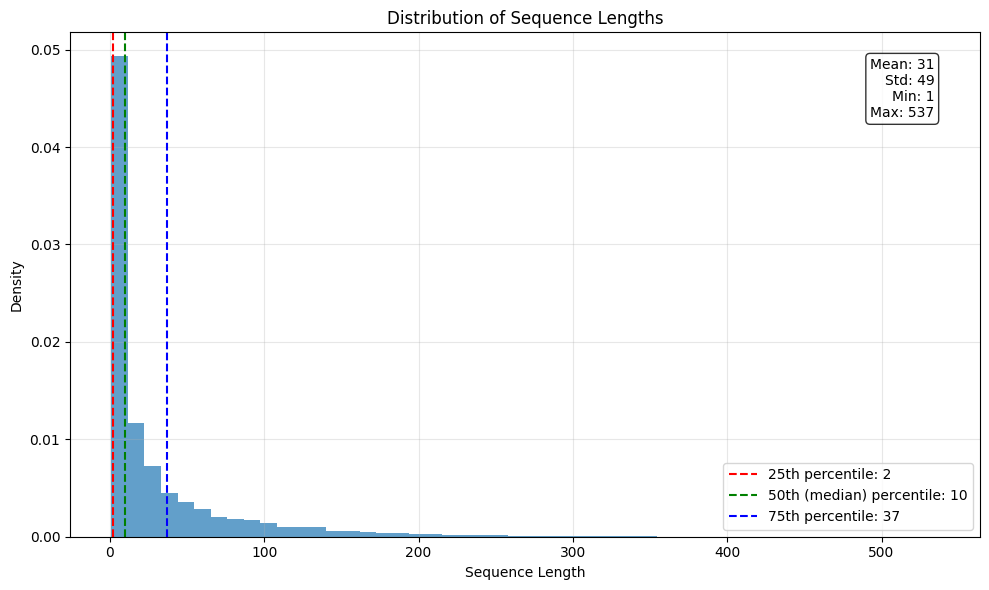

In [7]:
# Calculate quantiles
quantiles = [0.25, 0.5, 0.75]
q_values = np.quantile(sequence_lengths, quantiles)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram
n, bins, patches = plt.hist(sequence_lengths, bins=50, density=True, alpha=0.7)

# Add vertical lines for quantiles
colors = ["r", "g", "b"]
labels = ["25th", "50th (median)", "75th"]
for q, c, l in zip(q_values, colors, labels):  # noqa: E741
    plt.axvline(x=q, color=c, linestyle="--", label=f"{l} percentile: {int(q)}")

# Customize plot
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)

# Add text with statistics
stats_text = f"Mean: {int(np.mean(sequence_lengths))}\n"
stats_text += f"Std: {int(np.std(sequence_lengths))}\n"
stats_text += f"Min: {int(np.min(sequence_lengths))}\n"
stats_text += f"Max: {int(np.max(sequence_lengths))}"
plt.text(
    0.95,
    0.95,
    stats_text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

In [8]:
# keep only sequences within the 25th to 75th percentile
sequences = [
    sequence
    for sequence in sequences
    if len(sequence) >= int(q_values[0]) and len(sequence) <= int(q_values[2])
]

In [9]:
from project_permed.sequence import similarity_score

# Example usage:
sequence1 = sequences[8]
sequence2 = sequences[54]
score = similarity_score(sequence1, sequence2)
print(f"Sequences: {sequence1} and {sequence2}")
print(f"Similarity score: {score}")

Sequences: [1, 0, 1, 1, 0, 1, 0, 1] and [7, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1]
Similarity score: 0.0


In [10]:
# Example usage:
sequence1 = [5, 2, 0, 5, 3]
sequence2 = [7, 5, 3]
score = similarity_score(sequence1, sequence2)
print(f"Sequences: {sequence1} and {sequence2}")
print(f"Similarity score: {score}")

Sequences: [5, 2, 0, 5, 3] and [7, 5, 3]
Similarity score: 1.414213562373095


In [11]:
from project_permed.sequence import cluster


def analyze_clusters(sequences: list, clusters: np.ndarray):
    """
    Analyze the characteristics of each cluster, including ending drugs
    and drugs used before ending
    """
    unique_clusters = np.unique(clusters)

    for cluster_id in unique_clusters:
        # Get sequences in this cluster
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_sequences = [sequences[i] for i in cluster_indices]

        # Calculate basic statistics
        lengths = [len(seq) for seq in cluster_sequences]

        print(f"\nCluster {cluster_id}:")
        print(f"Number of sequences: {len(cluster_sequences)}")
        print(f"Average sequence length: {np.mean(lengths):.2f}")
        print(f"Length range: {min(lengths)} - {max(lengths)}")

        # Calculate average pairwise similarity within cluster
        if len(cluster_sequences) > 1:
            similarities = []
            for i in range(len(cluster_sequences)):
                for j in range(i + 1, len(cluster_sequences)):
                    sim = similarity_score(cluster_sequences[i], cluster_sequences[j])
                    similarities.append(sim)
            print(f"Average pairwise similarity score: {np.mean(similarities):.2f}")

        # Analyze common patterns
        all_periods = []
        before_ending_drugs = []  # New list for drugs used before ending
        for seq in cluster_sequences:
            periods = [period for period in "".join(map(str, seq)).split("0") if period]
            all_periods.extend(periods)

            # Collect drugs used before ending
            for period in periods:
                period_nums = [int(x) for x in period]
                if len(period_nums) > 1:
                    before_ending_drugs.extend(period_nums[:-1])

        # Find most common ending drugs
        endings = [int(period[-1]) for period in all_periods]
        unique_endings, ending_counts = np.unique(endings, return_counts=True)
        top_endings = sorted(
            zip(unique_endings, ending_counts), key=lambda x: x[1], reverse=True
        )[:3]

        print("\nMost common ending drugs:")
        for drug, count in top_endings:
            percentage = (count / len(all_periods)) * 100
            print(f"  Drug {drug}: {count} times ({percentage:.1f}%)")

        # Analyze drugs used before ending
        if before_ending_drugs:
            unique_before, before_counts = np.unique(
                before_ending_drugs, return_counts=True
            )
            top_before = sorted(
                zip(unique_before, before_counts), key=lambda x: x[1], reverse=True
            )[:3]

            print("\nMost common drugs used before ending:")
            total_before = len(before_ending_drugs)
            for drug, count in top_before:
                percentage = (count / total_before) * 100
                print(f"  Drug {drug}: {count} times ({percentage:.1f}%)")


# Use it after clustering
clusters, linkage_matrix = cluster(sequences, n_clusters=10)
analyze_clusters(sequences, clusters)


Cluster 1:
Number of sequences: 72
Average sequence length: 10.89
Length range: 2 - 36
Average pairwise similarity score: 1.50

Most common ending drugs:
  Drug 5: 142 times (73.6%)
  Drug 2: 14 times (7.3%)
  Drug 1: 10 times (5.2%)

Most common drugs used before ending:
  Drug 5: 332 times (70.6%)
  Drug 2: 73 times (15.5%)
  Drug 3: 30 times (6.4%)

Cluster 2:
Number of sequences: 344
Average sequence length: 13.69
Length range: 2 - 37
Average pairwise similarity score: 1.61

Most common ending drugs:
  Drug 3: 655 times (76.0%)
  Drug 2: 51 times (5.9%)
  Drug 1: 49 times (5.7%)

Most common drugs used before ending:
  Drug 3: 2752 times (82.6%)
  Drug 7: 199 times (6.0%)
  Drug 2: 134 times (4.0%)

Cluster 3:
Number of sequences: 280
Average sequence length: 13.71
Length range: 2 - 37
Average pairwise similarity score: 1.77

Most common ending drugs:
  Drug 6: 676 times (72.9%)
  Drug 7: 67 times (7.2%)
  Drug 2: 54 times (5.8%)

Most common drugs used before ending:
  Drug 6: 17

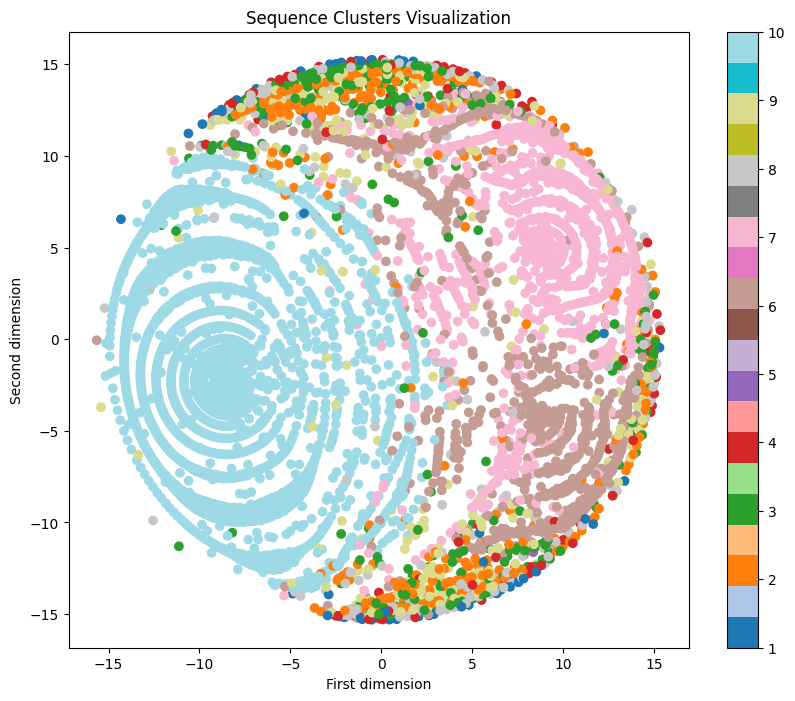

In [12]:
from sklearn.manifold import MDS
from project_permed.sequence import create_distance_matrix


def visualize_clusters(sequences: list, clusters: np.ndarray):
    """
    Visualize clusters using MDS for dimensionality reduction
    """
    # Create distance matrix
    dist_matrix = create_distance_matrix(sequences)

    # Use MDS to reduce to 2D
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords_2d = mds.fit_transform(dist_matrix)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], c=clusters, cmap="tab20")
    plt.colorbar(scatter)
    plt.title("Sequence Clusters Visualization")
    plt.xlabel("First dimension")
    plt.ylabel("Second dimension")
    plt.show()


# Visualize the clusters
visualize_clusters(sequences, clusters)

In [13]:
# Print cluster sizes and random sample sequences from each cluster
for cluster_id in np.unique(clusters):
    cluster_sequences = [sequences[i] for i in np.where(clusters == cluster_id)[0]]
    print(f"\nCluster {cluster_id}: {len(cluster_sequences)} sequences")

    # Get sample sequences
    sample_size = min(5, len(cluster_sequences))
    # Use random.sample instead of np.random.choice
    sample_sequences = random.sample(cluster_sequences, sample_size)

    print("Sample sequences:")
    for i, seq in enumerate(sample_sequences, 1):
        print(f"  {i}. {seq}")


Cluster 1: 72 sequences
Sample sequences:
  1. [5, 5, 5, 5]
  2. [5, 5]
  3. [5, 5, 5, 5, 5]
  4. [5, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
  5. [1, 0, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5]

Cluster 2: 344 sequences
Sample sequences:
  1. [2, 0, 2, 2, 3, 2, 0, 2, 2]
  2. [5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 1]
  3. [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
  4. [3, 3, 3, 3]
  5. [3, 3, 3, 3, 3, 3]

Cluster 3: 280 sequences
Sample sequences:
  1. [6, 6, 0, 6, 6, 6, 6, 6, 0, 7, 7, 7, 7, 7, 0, 1]
  2. [6, 6, 6, 6]
  3. [6, 6]
  4. [6, 6]
  5. [6, 0, 6, 6, 0, 6, 0, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2]

Cluster 4: 93 sequences
Sample sequences:
  1. [4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
  2. [4, 4, 0, 4]
  3. [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 4]
  4. [4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1]
  5. [4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4]

Cluster 5: 2

In [14]:
atc_code_to_num

{'N06AA09': 1,
 'N06AB04': 2,
 'N06AB06': 3,
 'N06AX16': 4,
 'N06AA07': 5,
 'N06AB05': 6,
 'N06AB03': 7,
 'N06AA16': 8,
 'N06AX11': 9}